In [1]:
import multiprocessing
from multiprocessing import Pool
import locale
import time
import pandas as pd
import cx_Oracle
import geopandas
from shapely.geometry import Point


In [5]:
# Simpel indlæsning af AIS Messages
locale.setlocale(locale.LC_ALL, 'Danish_Denmark.1252')
# process = psutil.Process(os.getpid())
conn = cx_Oracle.connect('/@STATPROD')
sql = """
select p.tid,
       p.aisnum,
       p.repeat,
       p.userid,
       p.status,
       p.rot,
       p.sog,
       p.posacc,
       p.cog,
       p.thead,
       p.manind,
       p.lon,
       p.lat
  from u900001.aispos p
 where p.tid between timestamp '2018-09-10 00:00:00'
                 and timestamp '2018-09-10 00:14:59' and
        p.lon between 7 and 16 and
        p.lat between 54 and 58 and
        p.sog < 2
 order by p.tid
"""

start = time.time()

df = pd.read_sql(sql, con=conn)

print(f"Rækker for dagen: {len(df):<n}")
print("Sekunder for indlæsning: {}".format(round(time.time() - start, 2)))
# print(f"Memory forbrug: {round(process.memory_info().rss / 1024 / 1024):<n} Mbytes")
conn.close()

# Rækker for dagen: 9.422.365
# Sekunder for indlæsning: 103.2
# Memory forbrug: 1.324 Mbytes

# sog=0
# Rækker for dagen: 3.999.526
# Sekunder for indlæsning: 50.64

Rækker for dagen: 51.458
Sekunder for indlæsning: 1.01


In [18]:
start = time.time()
%run -i HentHavne
# print(havn.head(2))
print("Sekunder for indlæsning: {}".format(round(time.time() - start, 2)))

Havnenes afgrænsning kan findes i pandas.DataFrame 'havn'.
        FOT_ID  TIMEOF_CRE  TIMEOF_PUB TIMEOF_REV  TIMEOF_EXP  \
0  1000258581  2015-11-24  2015-11-24       None  2018-08-30   
1  1000258584  2015-11-24  2015-11-24       None  2018-08-30   

                                             omkreds  
0  POLYGON ((11.92750653092829 55.93463287475144,...  
1  POLYGON ((11.90761472810529 55.93612765334725,...  
Sekunder for indlæsning: 1.93


In [21]:
start = time.time()

geometry = [Point(xy) for xy in zip(df.LON, df.LAT)]
crs = {'init': 'epsg:4326'}

gdf = geopandas.GeoDataFrame(df, crs=crs, geometry=geometry)

print("Sekunder for indlæsning: {}".format(round(time.time() - start, 2)))

Sekunder for indlæsning: 9.35


In [22]:
print(gdf.head(5))
sample = gdf.sample(100)
type(sample)

                      TID  AISNUM  REPEAT     USERID  STATUS  ROT  SOG  \
0 2018-09-10 00:00:00.022       1       0  211216490       0    0    0   
1 2018-09-10 00:00:00.022       1       0  245039000       0    0    1   
2 2018-09-10 00:00:00.022       1       0  235090202       0    0    0   
3 2018-09-10 00:00:00.022       1       0  211379620       0  128    0   
4 2018-09-10 00:00:00.069       1       0  219472000       0    0    0   

   POSACC   COG  THEAD  MANIND        LON        LAT  \
0       0  3410    181       0  12.093333  54.154167   
1       0  3074    293       0  13.681918  54.228655   
2       0  2487    280       0  13.656872  54.147950   
3       0     0    511       0   9.434390  54.790122   
4       0  3096    251       0   8.127252  56.001930   

                              geometry  
0          POINT (12.093333 54.154167)  
1          POINT (13.681918 54.228655)  
2  POINT (13.656872 54.14794999999999)  
3  POINT (9.434389999999999 54.790122)  
4   POINT (8.

geopandas.geodataframe.GeoDataFrame

In [ ]:
start = time.time()

test = geopandas.GeoDataFrame()
poly = list(havn['omkreds'])

def arbejdsproces(gdf) :
    for omkreds in poly :
        test = test.append(gdf[gdf.within(omkreds)])

with Pool(4) as p :
    p.map(arbejdsproces,gdf)
    
# print(type(test))
print("Sekunder for indlæsning: {}".format(round(time.time() - start, 2)))

In [80]:
print(test.shape)
print(test.head(2))
print(type(test))
test.to_pickle('havneanløb 10.9.2018.pkl')

(3515972, 14)
                            TID  AISNUM  REPEAT     USERID  STATUS  ROT  SOG  \
2279623 2018-09-10 05:54:10.110       3       0  220000054       0  127   53   
2279961 2018-09-10 05:54:13.172       3       0  220000054       0  127   53   

         POSACC   COG  THEAD  MANIND    LON      LAT               geometry  
2279623       0  1510    169       0  9.192  56.7015  POINT (9.192 56.7015)  
2279961       0  1520    172       0  9.192  56.7015  POINT (9.192 56.7015)  
<class 'geopandas.geodataframe.GeoDataFrame'>


In [13]:
test2 = test[test['SOG']!=0]
test2.shape

(436781, 14)

Procestiden har været 0 minutter og 58.86 sekunder.


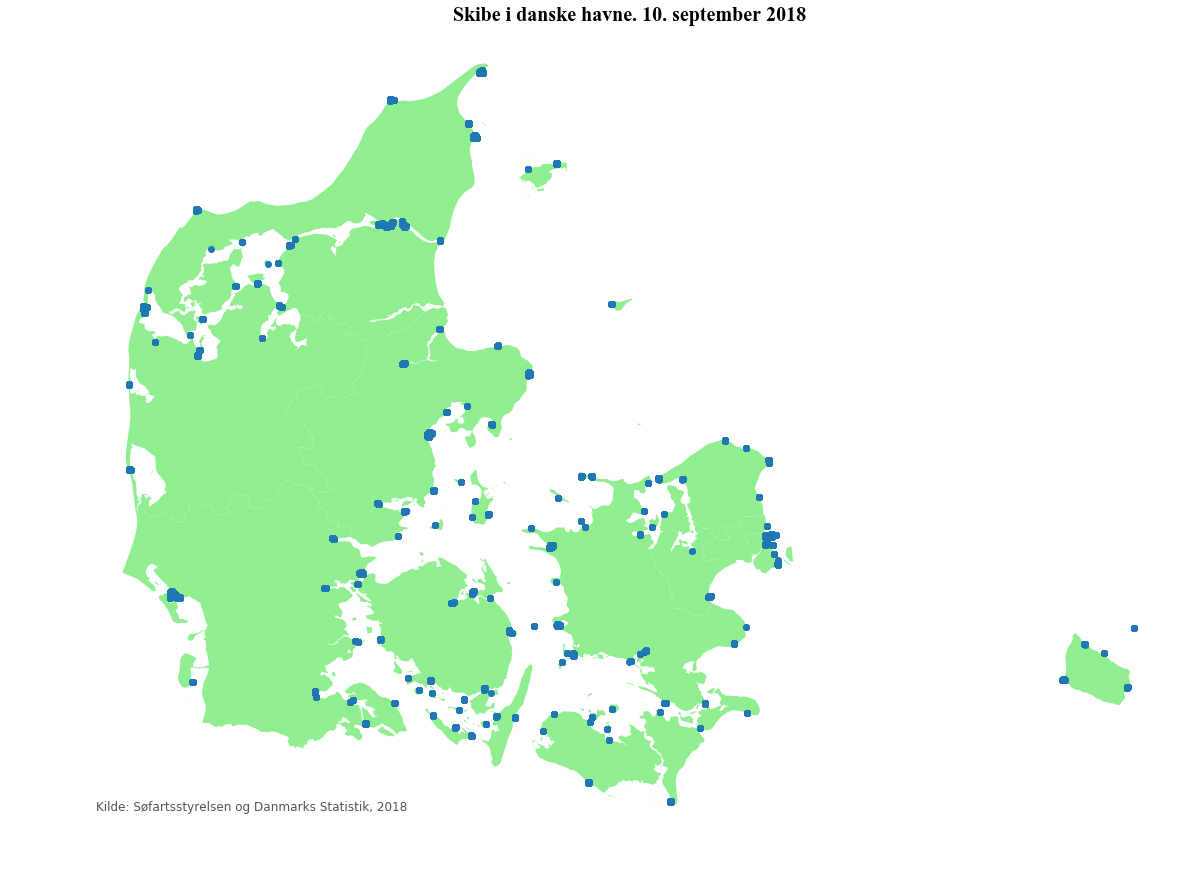

In [14]:
from matplotlib import pyplot as plt
t0 = time.time()
test = pd.read_pickle('havneanløb 10.9.2018.pkl')

url = 'geodata/NUTS_RG_01M_2016_4326_LEVL_3.geojson'
nuts3 = geopandas.read_file(url)
nuts3_dk = nuts3[nuts3['CNTR_CODE'].isin(['DK'])]
nuts3_dk2 = nuts3_dk.to_crs({'init': 'epsg:4326'})

fig, ax = plt.subplots(figsize=(20,15))
nuts3_dk2.plot(ax=ax, color='Lightgreen')
test2.plot(ax=ax)

ax.set_axis_off()

ax.set_title('Skibe i danske havne. 10. september 2018', loc='center',
             fontdict={'family': 'Times New Roman', 'fontsize': '20', 'fontweight': 3, 'variant': 'small-caps'})

ax.annotate('Kilde: Søfartsstyrelsen og Danmarks Statistik, 2018',xy=(0.08, 0.1),  \
            xycoords='figure fraction', horizontalalignment='left', \
            verticalalignment='top', fontsize=12, color='#555555')

t1 = time.time()
dt = t1 - t0
print("Procestiden har været {} minutter og {} sekunder.".format(int(dt / 60), round(dt%60, 2)))

fig.savefig('AIS skibe i havn.png')